# Conditional Normalizing Flow Model

Here, we train a conditional normalizing flow model $q(x|c)$. Our target $p(x|c)$ is a simple 2D Gaussian $\mathcal{N}(x|\mu, \sigma)$, where we condition on the mean $\mu$ and standard deviation $\sigma$, i.e. $c = (\mu, \sigma)$. We apply conditional autoregressive and coupling neural spline flows as well as a conditional masked autoregressive flow to the problem.

## Setup

In [2]:
# Import packages
import torch
import numpy as np
import normflows as nf

import uproot as up

from matplotlib import pyplot as plot
import math
from tqdm import tqdm
from util import PVect, theta_func, r_func
from IPython.display import clear_output


Using device cuda:0


In [3]:
# Get device to be used
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# # Data - closest x pos, 5GeV muons, one z position - emission time
# uproot_path = f"/cwork/rck32/eic/work_eic/root_files/July_1/slurm/mu_vary_z_theta/5GeV_500events_TEST.edm4hep.root:events" #(gun x 1769)
# events = up.open(uproot_path)

# hit_time_branch = events["HcalBarrelHits.time"].array(library='np')
# hit_x_pos_branch = events["HcalBarrelHits.position.x"].array(library='np')
# hit_z_pos_branch = events["HcalBarrelHits.position.z"].array(library='np')
# Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')


# x_pos_branch = events["MCParticles/MCParticles.vertex.x"].array(library='np')
# z_pos_branch = events["MCParticles/MCParticles.vertex.z"].array(library='np')
# PDG_branch = events["MCParticles.PDG"].array(library='np')
# mass_branch = events["MCParticles.mass"].array(library='np')

# momentum_x_branch = events["MCParticles.momentum.x"].array(library='np')
# momentum_y_branch = events["MCParticles.momentum.y"].array(library='np')
# momentum_z_branch = events["MCParticles.momentum.z"].array(library='np')

# emission_time_branch = events["MCParticles/MCParticles.time"].array(library='np')
# daughter_end_branch = events["MCParticles/MCParticles.daughters_end"].array(library='np')
# daughter_begin_branch = events["MCParticles/MCParticles.daughters_begin"].array(library='np')

#### Data preparation
Need 5 features:
1. Four conditionals:
    1. Hit z position (calculate from shoot position and angle)
    2. hit time (calculate from momentum and distance)
    3. hit theta (calculate from momentum vector)
    4. hit momenta (calculate from momentum vector)
2. Feature
    1. photon hit time on sensor

##### Status
1. Hit z, hit theta, hit momenta and photon hit time are all good
1. Just need to calculate hit time from momentum (velocity) and distance traveled (use pythogorean theorem with x and z)

### Preprocess manually below if not loading data

In [17]:
# break_limit = 1000
# init = False
# inputs = torch.ones(1,5)
# for file_num in range(21):
#     clear_output(wait = True)
#     print(f"Beginning file #{file_num}")
# #     uproot_path = f"/cwork/rck32/eic/work_eic/root_files/July_1/slurm/mu_vary_z_theta/5GeV_200events_{file_num}.edm4hep.root:events" #keep all particles
#     uproot_path = f"/cwork/rck32/eic/work_eic/root_files/July_2/slurm/mu_vary_z_theta_no_save_all/5GeV_4000events_{file_num}.edm4hep.root:events"
#     with up.open(uproot_path) as events:
#         hit_time_branch = events["HcalBarrelHits.time"].array(library='np')
#         hit_x_pos_branch = events["HcalBarrelHits.position.x"].array(library='np')
#         hit_z_pos_branch = events["HcalBarrelHits.position.z"].array(library='np')
#         Hits_MC_idx_branch = events["_HcalBarrelHits_MCParticle.index"].array(library='np')


#         x_pos_branch = events["MCParticles/MCParticles.vertex.x"].array(library='np')
#         z_pos_branch = events["MCParticles/MCParticles.vertex.z"].array(library='np')
#         PDG_branch = events["MCParticles.PDG"].array(library='np')
#         mass_branch = events["MCParticles.mass"].array(library='np')

#         momentum_x_branch = events["MCParticles.momentum.x"].array(library='np')
#         momentum_y_branch = events["MCParticles.momentum.y"].array(library='np')
#         momentum_z_branch = events["MCParticles.momentum.z"].array(library='np')

#         emission_time_branch = events["MCParticles/MCParticles.time"].array(library='np')
#         daughter_end_branch = events["MCParticles/MCParticles.daughters_end"].array(library='np')
#         daughter_begin_branch = events["MCParticles/MCParticles.daughters_begin"].array(library='np')
        
#         for event_idx in range(len(PDG_branch)):
#             clear_output(wait = True)
#             print(f"Working on file #{file_num}: {event_idx} events done")
#             if(break_limit > 0 and event_idx > break_limit):
#                 break
#             #Primary stuff
#             primary = PVect()
#             primary.setVector(momentum_x_branch[event_idx][0],momentum_y_branch[event_idx][0],momentum_z_branch[event_idx][0],mass_branch[event_idx][0])
#             theta = primary.theta
#             P = primary.P
#             px = primary.px
#             m = primary.M
#             vertex_x = x_pos_branch[event_idx][0]
#             vertex_z = z_pos_branch[event_idx][0]
#             mu_incident_time = time_func(px,m,1770.3 - vertex_x) #for one_segment, bar starts at 1770.3 mm
#             for hit_idx in range(len(hit_z_pos_branch[event_idx])):
#                 if(PDG_branch[event_idx][Hits_MC_idx_branch[event_idx][hit_idx]] != -22):
#                     continue
#                 #conditionals
#                 hit_z = z_func(vertex_z, theta)
#                 hit_tensor = torch.ones(1,5) * 10
#                 hit_tensor[0,0] = float(hit_z)
#                 hit_tensor[0,1] = float(mu_incident_time)
#                 hit_tensor[0,2] = float(theta)
#                 hit_tensor[0,3] = float(P)
#                 #features
#                 sensor_time = hit_time_branch[event_idx][hit_idx]
#                 hit_tensor[0,4] = float(sensor_time)
#                 if(not init):
#                     inputs[0] = hit_tensor[0]
#                     init = True
#                 else:
#                     inputs = torch.cat((inputs,hit_tensor),0)

        

### Load data from .pt file (created by preprocess.py)

In [26]:
inputs = torch.load("data/July_03/Run_0/test_1file_100events.pt")

In [27]:
inputs.shape

torch.Size([29486, 5])

In [21]:
inputs.shape #file 10, 100 events

torch.Size([29494, 5])

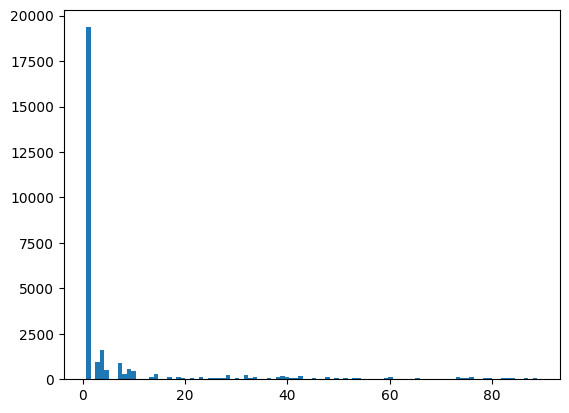

In [28]:
plot.hist(inputs[:,2],bins = 100);

In [70]:
indexes = torch.randperm(inputs.shape[0])
dataset = inputs[indexes]
train_frac = 0.9
train_lim = int(np.floor(dataset.shape[0] * train_frac))
train_data = dataset[:train_lim]
test_data = dataset[train_lim:]

## Masked Autoregressive Flow

### Model specification

In [72]:
# Define flows
K = 4

latent_size = 1
hidden_units = 128
num_blocks = 2
context_size = 4

flows = []
for i in range(K):
    flows += [nf.flows.MaskedAffineAutoregressive(latent_size, hidden_units, 
                                                  context_features=context_size, 
                                                  num_blocks=num_blocks)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set base distribution
q0 = nf.distributions.DiagGaussian(1, trainable=False)
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(q0, flows)

# Move model on GPU if available
model = model.to(device)

### Training

100%|██████████| 5145/5145 [01:31<00:00, 56.52it/s]


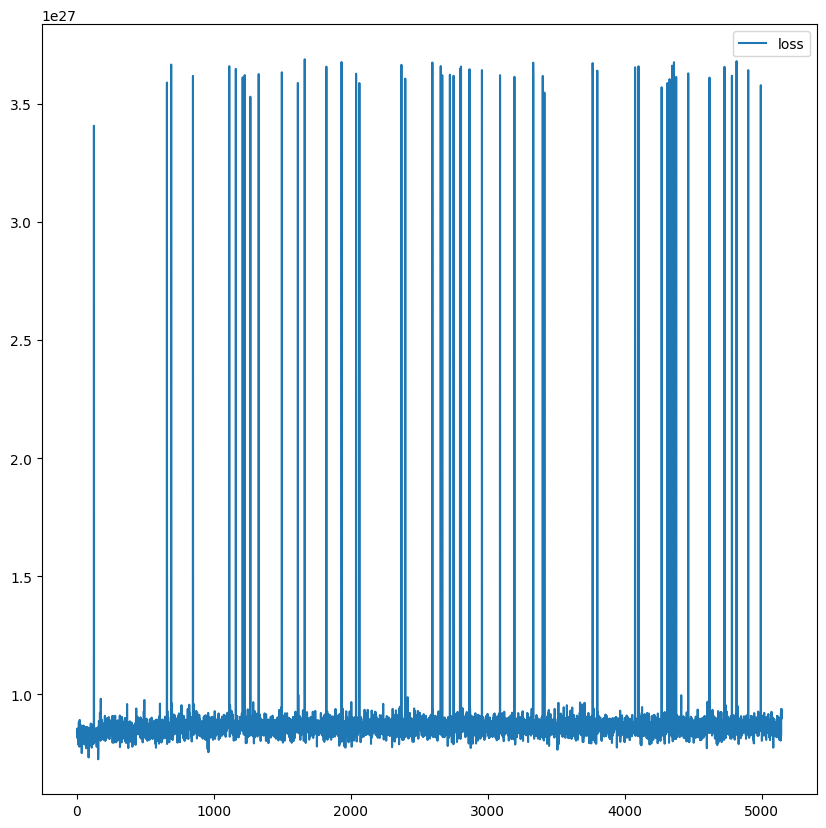

In [73]:
# Train model

num_context = 4

batch_size= 128
max_iter = int(np.floor(train_data.shape[0] / batch_size))

loss_hist = np.array([])

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
for it in tqdm(range(max_iter)):
    optimizer.zero_grad()
    
    # Get training samples
    begin = it * batch_size
    end = (it + 1) * batch_size
    it_data = train_data[begin:end]
    context = it_data[:,:num_context].to(device)
    samples = it_data[:,num_context].unsqueeze(1).to(device)
    
    # Compute loss
    loss = model.forward_kld(samples, context)
    
    # Do backprop and optimizer step
    if ~(torch.isnan(loss) | torch.isinf(loss)):
        loss.backward()
        optimizer.step()
    
    # Log loss
    loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

### Evaluation

In [ ]:
test_data.to('cpu')
model.to('cpu')
model.eval()
samples = model.sample(num_samples = test_data.shape[0], context = test_data[:,:num_context])[0].cpu().detach().numpy()
model.train()
samples_cut = []
for i in range(len(samples)):
    if(samples[i] > 10000 or samples[i] < -10000):
        continue
    samples_cut.append(samples[i])
plot.hist(samples_cut,bins = 100);

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f8ce0c82be0>>
Traceback (most recent call last):
  File "/cwork/rck32/ML_venv/lib64/python3.9/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [ ]:
len(samples)